<a href="https://colab.research.google.com/github/hoangtheanhhp/ZaloQA/blob/bert_lstm/QASystem/run_zalo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!rm -rf zalo
!test -d zalo || git clone https://github.com/hoangtheanhhp/ZaloQA zalo
import sys
if 'zalo' not in sys.path:
  sys.path+=['zalo']

Cloning into 'zalo'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 715 (delta 124), reused 93 (delta 44), pack-reused 516
Receiving objects: 100% (715/715), 95.39 MiB | 20.64 MiB/s, done.
Resolving deltas: 100% (352/352), done.
Checking out files: 100% (42/42), done.


In [1]:
%tensorflow_version 1.x
!pip install kashgari==1.1.4



TensorFlow 1.x selected.


In [0]:
DATASET_PATH = "zalo/Dataset/zalo"
SAVE_MODEL_PATH = "/content/drive/My Drive/ZaloAI/result/model_bert"
MODEL_PATH = "/content/drive/My Drive/ZaloAI/bert"

In [4]:
from zalo.QASystem.preprocess import ZaloDatasetProcessor

import kashgari
processor = ZaloDatasetProcessor()
from kashgari.embeddings import BERTEmbedding

bert_embedding = BERTEmbedding(MODEL_PATH,
                               task=kashgari.CLASSIFICATION,
                               sequence_length=512)

tokenizer = bert_embedding.tokenizer

/usr/local/lib/python3.6/dist-packages/bert4keras/__init__.py:22: UserWarning: bert4keras.bert has been renamed as bert4keras.models.
  warnings.warn('bert4keras.bert has been renamed as bert4keras.models.')
/usr/local/lib/python3.6/dist-packages/bert4keras/__init__.py:23: UserWarning: please use bert4keras.models.
  warnings.warn('please use bert4keras.models.')
/usr/local/lib/python3.6/dist-packages/bert4keras/__init__.py:44: UserWarning: bert4keras.tokenizer has been renamed as bert4keras.tokenizers.
  warnings.warn('bert4keras.tokenizer has been renamed as bert4keras.tokenizers.')
/usr/local/lib/python3.6/dist-packages/bert4keras/__init__.py:45: UserWarning: please use bert4keras.tokenizers.
  warnings.warn('please use bert4keras.tokenizers.')


In [0]:
# Our tokenizer already added the BOS([CLS]) and EOS([SEP]) token
# so we need to disable the default add_bos_eos setting.
bert_embedding.processor.add_bos_eos = False

In [0]:
processor.val_data = []
processor.train_data = []

In [0]:
processor.load_from_path("/content/zalo/Dataset","squad","squad_vi.json")

In [7]:
true_squad = []
false_squad = []
for data in processor.train_data:
  if data.get('label'):
    true_squad.append(data)
  else:
    false_squad.append(data)
print(len(true_squad))
print(len(false_squad))
processor.train_data = true_squad[:30000]
processor.train_data.extend(false_squad[0:22000])

0
0


In [8]:
processor.load_from_path(DATASET_PATH,"train", "train_full.json")
processor.load_from_path("/content/zalo/Dataset/zalo", "test","test_full.json")

data = processor.train_data
val = processor.test_data
train_x = []
train_y = []
val_x = []
val_y = []
for d in data:
  if d.get('text') and len(d.get('text')) > 0:
    train_x.append(tokenizer.tokenize(d.get('question')) + 
                    tokenizer.tokenize(d.get('text'))[1:])
    train_y.append(str(d.get('label', False)))

for d in val:
  val_x.append(tokenizer.tokenize(d.get('question')) + 
               tokenizer.tokenize(d.get('text'))[1:])
  val_y.append(str(d.get('label', False)))

print(len(train_x), len(train_y), len(val_x), len(val_y))


100%|██████████| 2061/2061 [00:00<00:00, 632459.80it/s]


18106 18106 2061 2061


[56, 80, 113, 99, 116, 129, 86, 146, 112, 36, 127, 112, 33, 230, 127, 55, 73, 178, 122, 149, 78, 97, 85, 203, 263, 74, 115, 82, 106, 47, 56, 185, 108, 88, 168, 98, 147, 168, 123, 165, 227, 55, 118, 49, 87, 296, 111, 127, 100, 105, 142, 47, 178, 125, 97, 51, 142, 47, 73, 122, 140, 54, 119, 105, 53, 63, 123, 42, 107, 126, 78, 99, 73, 73, 88, 149, 80, 148, 206, 53, 115, 147, 78, 91, 135, 70, 229, 128, 119, 106, 107, 102, 180, 56, 87, 90, 285, 123, 44, 51, 276, 55, 87, 106, 86, 62, 131, 77, 120, 47, 62, 34, 152, 116, 95, 35, 54, 41, 77, 67, 159, 145, 111, 63, 76, 162, 73, 56, 309, 36, 68, 92, 87, 54, 80, 106, 90, 133, 185, 63, 94, 60, 159, 96, 157, 173, 66, 72, 130, 42, 65, 89, 164, 221, 118, 116, 458, 90, 366, 55, 72, 99, 94, 113, 73, 107, 97, 86, 174, 91, 94, 118, 112, 184, 68, 96, 252, 98, 139, 249, 91, 90, 81, 46, 107, 51, 29, 113, 125, 79, 85, 64, 141, 124, 121, 174, 112, 92, 81, 41, 40, 65, 74, 132, 113, 30, 137, 142, 75, 134, 169, 45, 46, 371, 40, 72, 81, 91, 84, 114, 69, 150, 61, 1

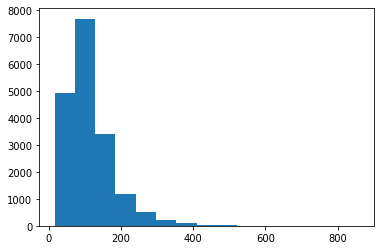

In [10]:
import matplotlib.pyplot as plt
len_train = []
for t in train_x:
  len_train.append(len(t))
print(len_train)
plt.hist(len_train, bins=15)
plt.show()


In [11]:
from kashgari.tasks.classification import BiLSTM_Model

import logging
logging.basicConfig(level='DEBUG')

model = BiLSTM_Model(bert_embedding)

model.fit(train_x,
          train_y,
          val_x,
          val_y,
          epochs=5,
          batch_size=128)

model.save(SAVE_MODEL_PATH)


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 512)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 512, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 512, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
from kashgari.utils import load_model

model = load_model(SAVE_MODEL_PATH)

In [0]:

test = processor.test_data
test_x = []
test_y = []
for d in test:
  test_x.append(tokenizer.tokenize(d.get('question')) + 
               tokenizer.tokenize(d.get('text'))[1:])
  test_y.append(str(d.get('label')))

In [13]:
# evaluate the model
model.evaluate(test_x, test_y)

              precision    recall  f1-score   support

       False     0.8437    0.8730    0.8581      1583
        True     0.5248    0.4644    0.4928       478

    accuracy                         0.7783      2061
   macro avg     0.6843    0.6687    0.6755      2061
weighted avg     0.7698    0.7783    0.7734      2061

